<a href="https://colab.research.google.com/github/aianshay/sales-time-series/blob/main/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 63 kB 6.3 MB/s 
     |████████████████████████████████| 6.4 MB 11.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Imports

In [3]:
import yfinance as yf

In [4]:
from sklearn.model_selection import cross_val_score, train_test_split

In [5]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [8]:
import matplotlib as mpl

In [9]:
mpl.rcParams['figure.figsize'] = [10, 5]

# Store Sales

### Loading data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
sales = pd.read_csv('/content/drive/MyDrive/sales.csv')
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
sales['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [13]:
df = sales.query('store_nbr == 1 and family == "PERSONAL CARE"')
df.head()

,id,date,store_nbr,family,sales,onpromotion
25,25,2013-01-01,1,PERSONAL CARE,0.0,0
1807,1807,2013-01-02,1,PERSONAL CARE,194.0,0
3589,3589,2013-01-03,1,PERSONAL CARE,153.0,0
5371,5371,2013-01-04,1,PERSONAL CARE,88.0,0
7153,7153,2013-01-05,1,PERSONAL CARE,141.0,0


In [14]:
df_sales = df.drop(columns=['id', 'store_nbr', 'family', 'onpromotion'])
df_sales.head()

,date,sales
25,2013-01-01,0.0
1807,2013-01-02,194.0
3589,2013-01-03,153.0
5371,2013-01-04,88.0
7153,2013-01-05,141.0


Plotando a série temporal

<Figure size 720x36000 with 0 Axes>

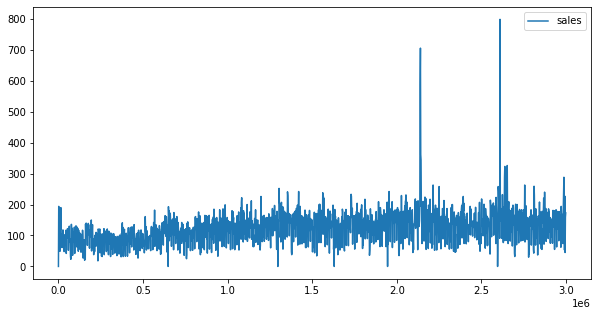

In [15]:
plt.figure(figsize=(10,500))

df_sales.plot()

 Convertendo a data para datetime

In [16]:
df_sales['date'] = pd.to_datetime(df_sales['date'])

#### Incluindo Feriados

In [17]:
# holidays_events = pd.read_csv('/content/drive/MyDrive/holidays_events.csv')
# holidays_events.head()

In [18]:
# holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [19]:
# def add_h_events(x):
#   if(x['date'] in list(holidays_events['date'])):
#     x['h_events'] = 1
#   return x

In [20]:
# df_sales['h_events'] = 0
# df_sales = df_sales.apply(add_h_events, axis=1)

In [21]:
# df_sales[df_sales['h_events'] == 1]

Incluindo index

In [22]:
df_sales.index = df_sales.date
df_sales = df_sales.drop(columns=['date'])
df_sales.head()

,sales
date,
2013-01-01,0.0
2013-01-02,194.0
2013-01-03,153.0
2013-01-04,88.0
2013-01-05,141.0


### Análise

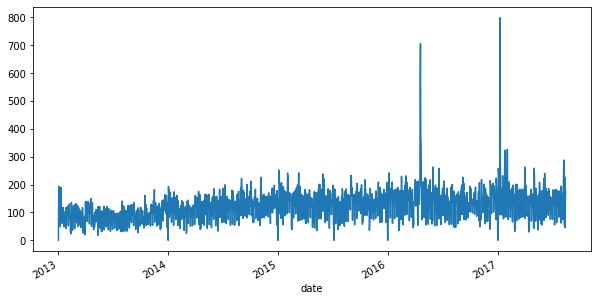

In [23]:
df_sales['sales'].fillna(method='bfill').plot()

In [24]:
df_sales.fillna(method='bfill', inplace=True)

In [25]:
sales_decomp = tsa.seasonal_decompose(df_sales['sales'], period=365)

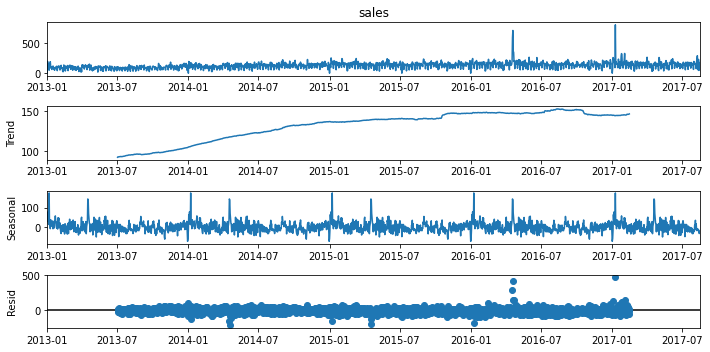

In [26]:
sales_decomp.plot();

#### Stationarity

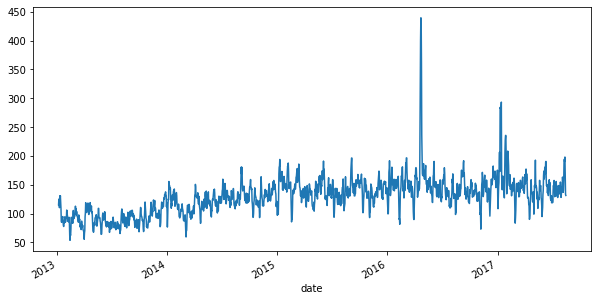

In [27]:
df_sales['sales'].rolling(5).mean().plot()

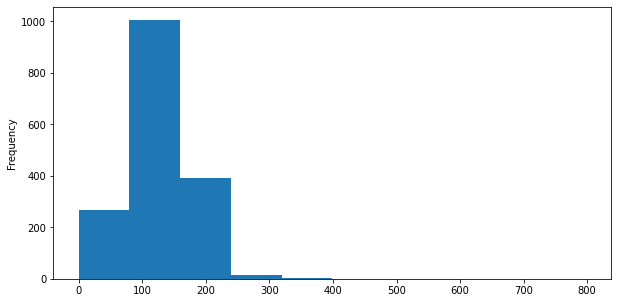

In [28]:
df_sales['sales'].plot.hist()

#### Diferentiation 1st order (d)

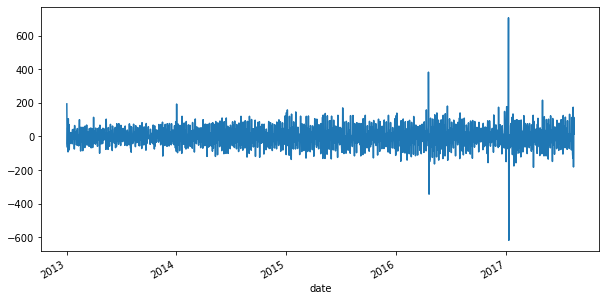

In [29]:
df_sales['sales'].diff().plot()

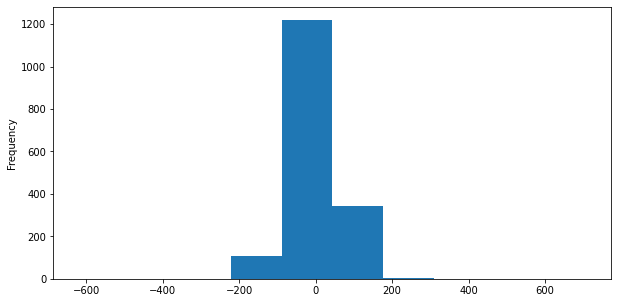

In [30]:
df_sales['sales'].diff().plot.hist()

In [31]:
salesd1 = pd.DataFrame(df_sales['sales']).diff().dropna()

#### Autocorrelation

A correlation of a variable with itself at different times
is known as autocorrelation or serial correlation.

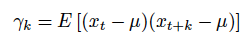

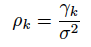

In [32]:
df_sales.shift(-1)

,sales
date,
2013-01-01,194.0
2013-01-02,153.0
2013-01-03,88.0
2013-01-04,141.0
2013-01-05,49.0
...,...
2017-08-11,227.0
2017-08-12,45.0
2017-08-13,159.0


In [33]:
pd.DataFrame(df_sales['sales']).corrwith(pd.DataFrame(df_sales['sales']).shift(-1))

sales    0.278298
dtype: float64

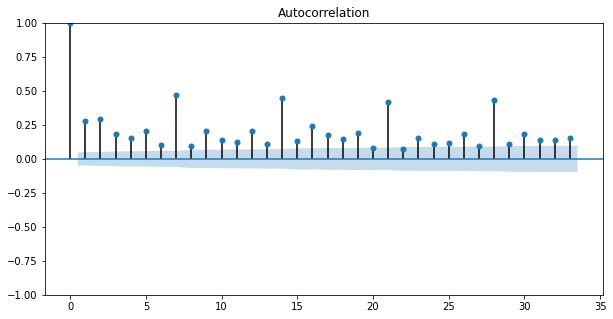

In [34]:
plot_acf(df_sales['sales']);

In [35]:
salesd1.corrwith(salesd1.shift(-1))

sales   -0.507911
dtype: float64

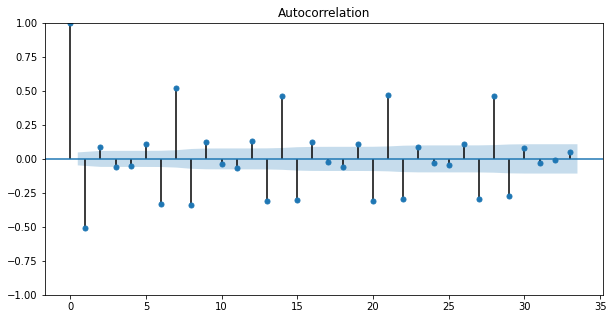

In [36]:
plot_acf(salesd1);

#### Partial Correlation

The partial autocorrelation at lag k is the correlation that
results after removing the effect of any correlations due to the terms at shorter
lags.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


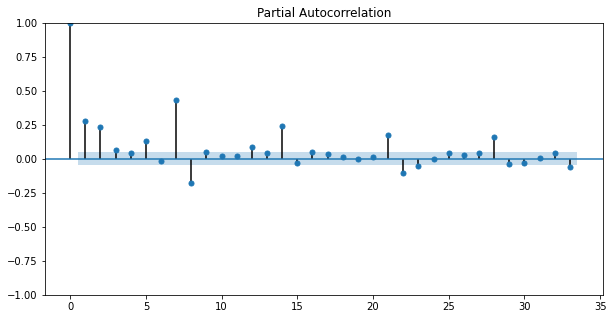

In [37]:
plot_pacf(df_sales['sales']);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


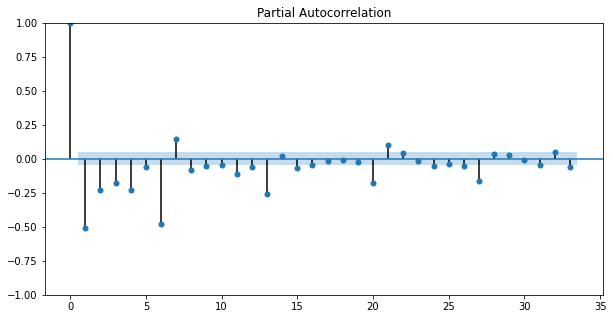

In [38]:
plot_pacf(salesd1);

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

### Feature Engineering

In [39]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [40]:
get_lags(df_sales, 3)

,sales-1,sales-2,sales-3
date,,,
2013-01-04,153.0,194.0,0.0
2013-01-05,88.0,153.0,194.0
2013-01-06,141.0,88.0,153.0
2013-01-07,49.0,141.0,88.0
2013-01-08,154.0,49.0,141.0
...,...,...,...
2017-08-11,183.0,288.0,239.0
2017-08-12,53.0,183.0,288.0
2017-08-13,227.0,53.0,183.0


In [41]:
X = get_lags(df_sales, 5)
y = df_sales.reindex(X.index)['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.333)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1259, 5)
(1259,)
(420, 5)
(420,)


In [42]:
y

date
2013-01-06     49.0
2013-01-07    154.0
2013-01-08    119.0
2013-01-09    190.0
2013-01-10    110.0
              ...  
2017-08-11     53.0
2017-08-12    227.0
2017-08-13     45.0
2017-08-14    159.0
2017-08-15    173.0
Name: sales, Length: 1679, dtype: float64

# KNN

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_nca_illustration_001.png)

![KNN](https://scikit-learn.org/stable/_images/sphx_glr_plot_regression_001.png)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

Hyperparameters:

* K 
* weights
* distance

In [43]:
from sklearn.neighbors import KNeighborsRegressor

In [44]:
neigh = KNeighborsRegressor(n_neighbors=4, weights='distance')
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4, weights='distance')

In [45]:
neigh.predict(X_test)[:10]

array([162.88534865, 144.95006286, 133.56248267, 138.26840395,
       151.09263001,  92.08728245, 163.72221771, 118.08714028,
       158.92988538, 140.73117262])

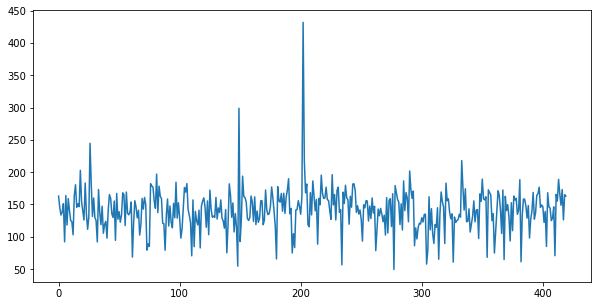

In [46]:
pd.Series(neigh.predict(X_test).flatten()).plot()

In [47]:
results = {}

In [48]:
print('Sales - KNN model Results')
results['KNN'] = {'mse': mean_squared_error(neigh.predict(X_test), y_test), 
                      'mae': mean_absolute_error(neigh.predict(X_test), y_test),
                      'mape': mean_absolute_percentage_error(neigh.predict(X_test), y_test)}
results['KNN']

Sales - KNN model Results


{'mae': 36.91103809886606,
 'mape': 0.28555438283630663,
 'mse': 3476.0058794864713}

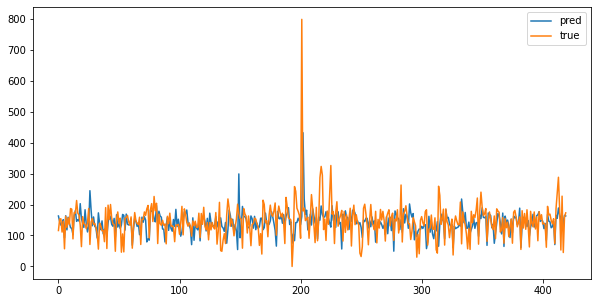

In [49]:
fig, ax = plt.subplots()
ax.plot(neigh.predict(X_test).flatten(), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.legend()

E agora?

In [50]:
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [51]:
neighd1 = KNeighborsRegressor(n_neighbors=4, weights='distance')
neighd1.fit(X_train_d1, y_train_d1)

KNeighborsRegressor(n_neighbors=4, weights='distance')

In [52]:
print('Sales d1 - KNN model Results')
results['KNN D1'] = {'mse': mean_squared_error(neighd1.predict(X_test), y_test), 
                 'mae': mean_absolute_error(neighd1.predict(X_test), y_test),
                 'mape': mean_absolute_percentage_error(neighd1.predict(X_test), y_test)}
results['KNN D1']

Sales d1 - KNN model Results


{'mae': 197.17038443120046,
 'mape': 5.748772848074336,
 'mse': 43141.353942665744}

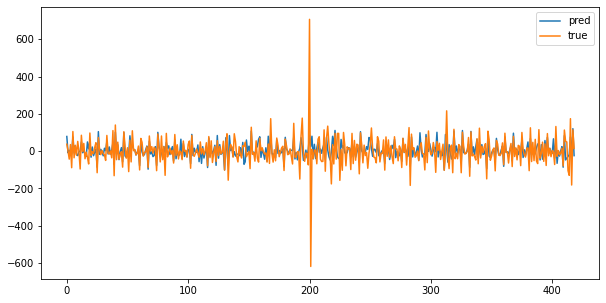

In [53]:
fig, ax = plt.subplots()
ax.plot(pd.Series(neighd1.predict(X_test_d1).flatten()), label='pred')
ax.plot(y_test_d1.reset_index(drop=True), label='true')
plt.legend()

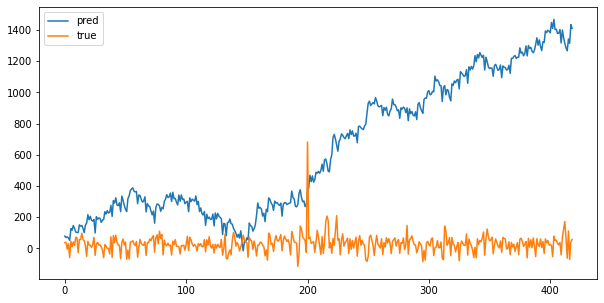

In [54]:
fig, ax = plt.subplots()
ax.plot(pd.Series(neighd1.predict(X_test_d1).flatten()).cumsum(), label='pred')
ax.plot(y_test_d1.reset_index(drop=True).cumsum(), label='true')
plt.legend()

Qual o problema dessa previsão?

 * Erro acumulado (problema em multi step recursivo)

In [55]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(neighd1.predict(X_test_d1).flatten(), name='sales'),axis=0)

In [56]:
pred_one

0             NaN
1      107.052451
2      156.892394
3      147.693964
4       95.077735
          ...    
415    258.757016
416     25.100431
417    347.318296
418     20.655711
419           NaN
Name: sales, Length: 420, dtype: float64

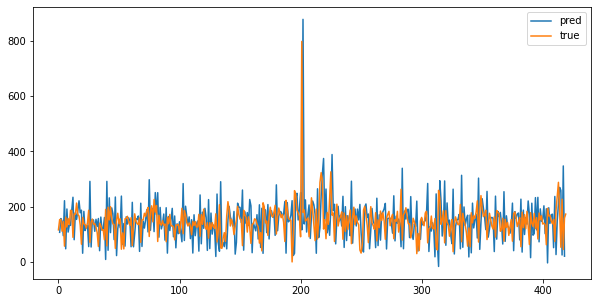

In [57]:
fig, ax = plt.subplots()
ax.plot(pred_one, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.legend()

In [58]:
pred_one

0             NaN
1      107.052451
2      156.892394
3      147.693964
4       95.077735
          ...    
415    258.757016
416     25.100431
417    347.318296
418     20.655711
419           NaN
Name: sales, Length: 420, dtype: float64

In [59]:
print('Sales pred_one - KNN model Results')
results['KNN D1 ONE'] = {'mse': mean_squared_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]), 
                 'mae': mean_absolute_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]),
                 'mape': mean_absolute_percentage_error(pred_one.iloc[1:-1], y_test.iloc[1:-1])}
results['KNN D1 ONE']

Sales pred_one - KNN model Results


{'mae': 76.81279991647129,
 'mape': 1.0699493648941913,
 'mse': 11560.754215955114}

In [60]:
residuos = neighd1.predict(X_test_d1).flatten() - y_test_d1.reset_index(drop=True).values.flatten()

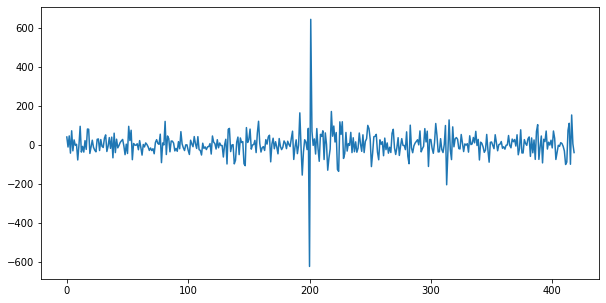

In [61]:
pd.Series(residuos).plot()

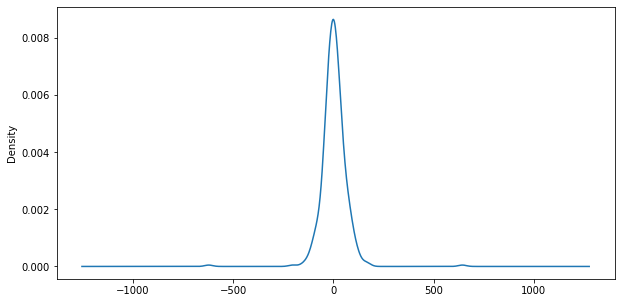

In [62]:
pd.Series(residuos).plot.kde()

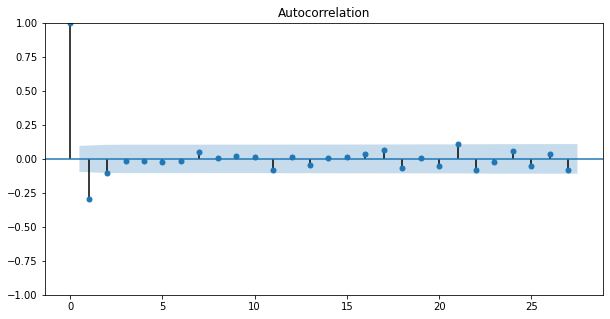

In [63]:
plot_acf(residuos);

## Grid search

In [64]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [65]:
parameters = {'n_neighbors':[5, 7], 'weights':['uniform', 'distance'], 
              'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']}

In [66]:
for p in parameters.items():
  print(p)

('n_neighbors', [5, 7])
('weights', ['uniform', 'distance'])
('algorithm', ['ball_tree', 'kd_tree', 'brute', 'auto'])


In [67]:
knn = KNeighborsRegressor()

In [68]:
knnGS = GridSearchCV(knn, parameters, cv=TimeSeriesSplit(n_splits=5))

In [69]:
knn_ = knnGS.fit(X_train, y_train)

In [70]:
print(knn_.best_score_)
print(knn_.best_params_)

0.06451398547335832
{'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}


In [71]:
print('KNN GS - model Results')

results['KNNGS'] = {'mse': mean_squared_error(knn_.predict(X_test), y_test), 
                    'mae': mean_absolute_error(knn_.predict(X_test), y_test),
                    'mape': mean_absolute_percentage_error(knn_.predict(X_test), y_test)}

results['KNNGS'] 

KNN GS - model Results


{'mae': 36.54936813059648,
 'mape': 0.28189243044171447,
 'mse': 3341.105751253721}

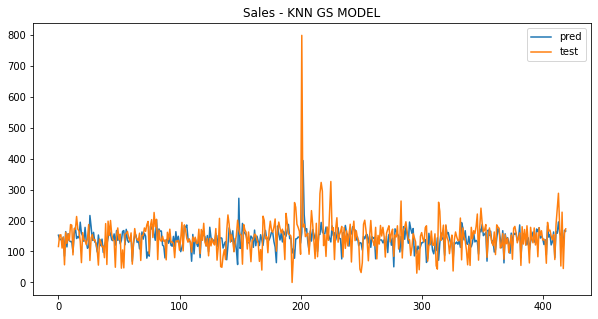

In [72]:
fig, ax = plt.subplots()
ax.plot(knn_.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='test')
plt.title('Sales - KNN GS MODEL')
plt.legend()

In [73]:
residuos_best = knn_.predict(X_test).flatten() - y_test.reset_index(drop=True).values.flatten()

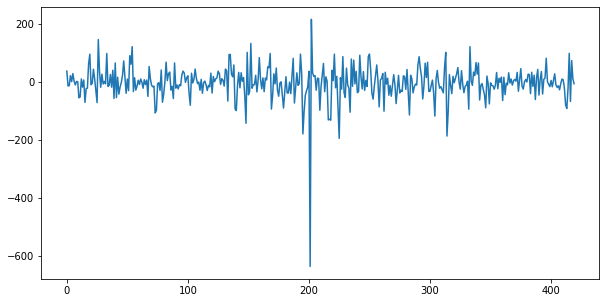

In [74]:
pd.Series(residuos_best).plot()

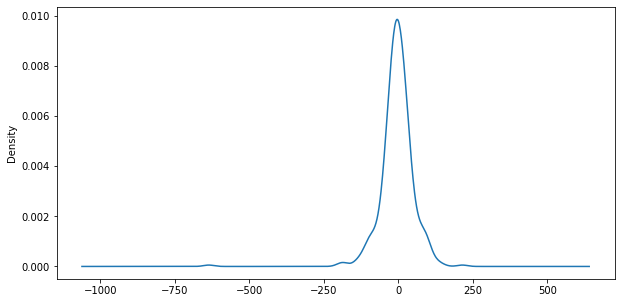

In [75]:
pd.Series(residuos_best).plot.kde()

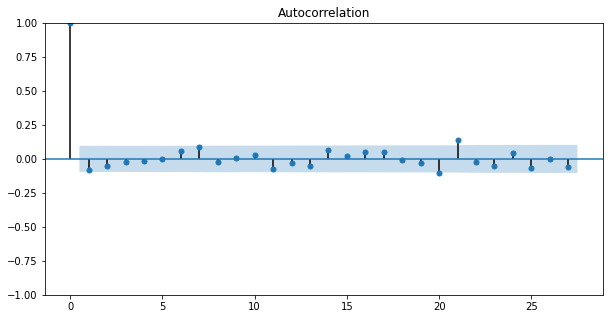

In [76]:
plot_acf(residuos_best);

In [77]:
pd.DataFrame(results)

,KNN,KNN D1,KNN D1 ONE,KNNGS
mse,3476.005879,43141.353943,11560.754216,3341.105751
mae,36.911038,197.170384,76.812800,36.549368
mape,0.285554,5.748773,1.069949,0.281892
